In [1]:
datafile = "nyc_311_data_subset-2.csv"

In [2]:
def read_311_data(datafile):
    import pandas as pd
    import numpy as np
    
    #Add the fix_zip function
    def fix_zip(input_zip):
        try:
            input_zip = int(float(input_zip))
        except:
            try:
                input_zip = int(input_zip.split('-')[0])
            except:
                return np.NaN
        if input_zip < 10000 or input_zip > 19999:
            return np.NaN
        return str(input_zip)
    
    #Read the file
    df = pd.read_csv(datafile,index_col='Unique Key')
    df.head()
    #fix the zip
    df['Incident Zip'] = df['Incident Zip'].apply(fix_zip)
    
    #drop all rows that have any nans in them (note the easier syntax!)
    
    df = df.dropna(how='any')
    
    #get rid of unspecified boroughs
    df = df[df['Borough'] != 'Unspecified']
    
    #Convert times to datetime and create a processing time column
    
    import datetime
    df['Created Date'] = df['Created Date'].apply(lambda x:datetime.
                                                  datetime.
                                                  strptime(x,'%m/%d/%Y %H:%M'))
    df['Closed Date'] = df['Closed Date'].apply(lambda x:datetime.
                                                datetime.
                                                strptime(x,'%m/%d/%Y %H:%M'))
    df['processing_time'] =  df['Closed Date'].subtract(df['Created Date'])
    
    #Finally, get rid of negative processing times and return the final data frame
    
    df = df[df['processing_time']>=datetime.timedelta(0,0,0)]
    
    return df

In [4]:
data = read_311_data(datafile)

C:\Users\VadymSerpak\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


## Plotting data on google maps

In [5]:
!pip install gmplot --upgrade

Requirement already up-to-date: gmplot in c:\users\vadymserpak\anaconda3\lib\site-packages
Requirement already up-to-date: requests in c:\users\vadymserpak\anaconda3\lib\site-packages (from gmplot)
Requirement already up-to-date: chardet<3.1.0,>=3.0.2 in c:\users\vadymserpak\anaconda3\lib\site-packages (from requests->gmplot)
Requirement already up-to-date: certifi>=2017.4.17 in c:\users\vadymserpak\anaconda3\lib\site-packages (from requests->gmplot)
Requirement already up-to-date: idna<2.7,>=2.5 in c:\users\vadymserpak\anaconda3\lib\site-packages (from requests->gmplot)
Requirement already up-to-date: urllib3<1.23,>=1.21.1 in c:\users\vadymserpak\anaconda3\lib\site-packages (from requests->gmplot)


In [6]:
!python -m pip install --upgrade pip

Requirement already up-to-date: pip in c:\users\vadymserpak\anaconda3\lib\site-packages


Our data dataframe contains latitudes and longitudes for each complaint. We can draw a heatmap that will help us see the relative concentration of complaints using lats and lons.

### GooleMapPlotter constructor
- GooleMapPlotter(center_lat,center_lng, zoom)
- from_geocode(location_string, zoom)

In [7]:
import gmplot

#gmap = gmplot.GoogleMapPlotter(40.7128,74.0059,8)
gmap = gmplot.GoogleMapPlotter.from_geocode("New York",10)

### Then generate the heatmap passing the two data series (latitude and longitude) to the function

In [8]:
gmap.heatmap(data['Latitude'],data['Longitude'])

### Save the heatmap to an html file

In [9]:
gmap.draw('incidents_311.html')

## Grouping operations
### Incidents by Borough
#### Group data by borough and plot a bar chart of the incident count

In [10]:
%matplotlib inline

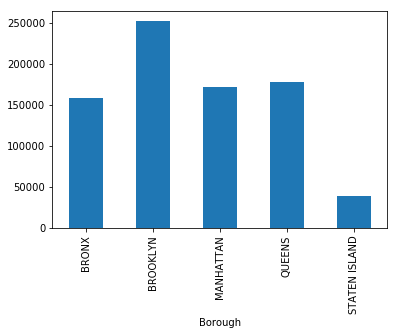

In [11]:
borough_group = data.groupby('Borough')
borough_group.size().plot(kind='bar')

### Incidents by Agency

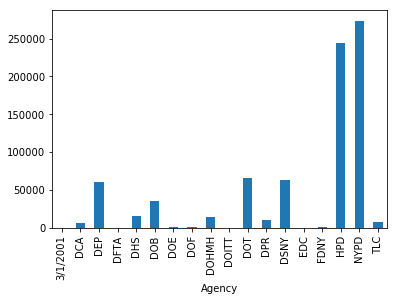

In [12]:
agency_group = data.groupby('Agency')
agency_group.size().plot(kind='bar')

Let's combine the two in a single graph

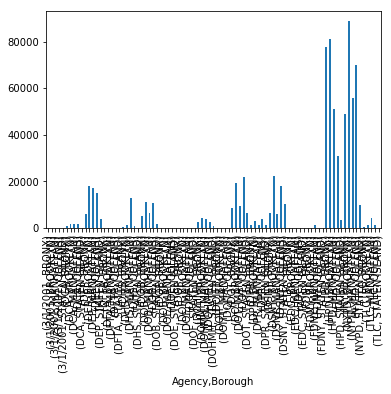

In [13]:
agency_borough = data.groupby(['Agency','Borough'])
agency_borough.size().plot(kind='bar')

####  This is quite unreadable and pointless!
We can unstack the groups so that we get borough by agency

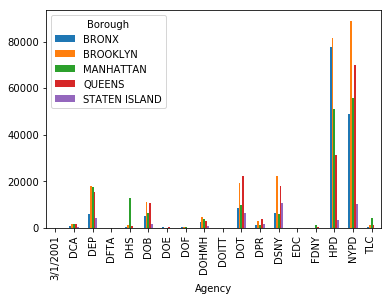

In [14]:
agency_borough.size().unstack().plot(kind='bar')

#### Increase the size of the image and add a title

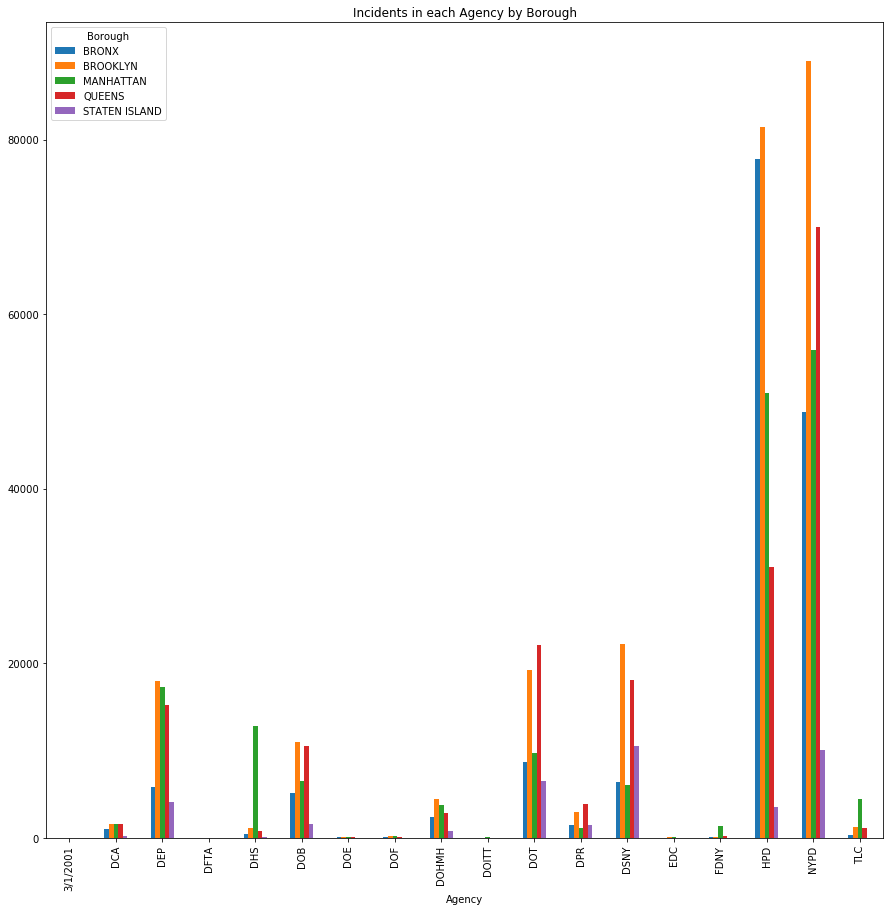

In [15]:
agency_borough = data.groupby(['Agency','Borough'])
agency_borough.size().unstack().plot(kind='bar',
                                     title='Incidents in each Agency by Borough',
                                    figsize=(15,15))

## Digression: The pandas.groupby()

In [16]:
import pandas as pd
writers = pd.DataFrame({'Author':['George Orwell','John Steinbeck',
                                  'Pearl Buck','Agatha Christie'],
                        'Country':['UK','USA','USA','UK'],
                        'Gender':['M','M','F','F'],
                        'Age':[46,66,80,85]})

In [17]:
writers

,Age,Author,Country,Gender
0,46,George Orwell,UK,M
1,66,John Steinbeck,USA,M
2,80,Pearl Buck,USA,F
3,85,Agatha Christie,UK,F


In [18]:
writers.groupby('Country').first()

,Age,Author,Gender
Country,,,
UK,46,George Orwell,M
USA,66,John Steinbeck,M


In [19]:
writers.groupby('Country').last()

,Age,Author,Gender
Country,,,
UK,85,Agatha Christie,F
USA,80,Pearl Buck,F


In [20]:
writers.groupby('Country').sum()

,Age
Country,
UK,131
USA,146


In [21]:
writers.groupby("Country").mean()

,Age
Country,
UK,65.5
USA,73.0


In [22]:
writers.groupby("Country").all()

,Age,Author,Gender
Country,,,
UK,True,True,True
USA,True,True,True


In [23]:
writers.groupby("Country").apply(sum)

,Age,Author,Country,Gender
Country,,,,
UK,131,George OrwellAgatha Christie,UKUK,MF
USA,146,John SteinbeckPearl Buck,USAUSA,MF


In [24]:
writers.groupby("Country").groups

{'UK': Int64Index([0, 3], dtype='int64'),
 'USA': Int64Index([1, 2], dtype='int64')}

In [25]:
grouped = writers.groupby(["Country","Gender"])
grouped.groups

{('UK', 'F'): Int64Index([3], dtype='int64'),
 ('UK', 'M'): Int64Index([0], dtype='int64'),
 ('USA', 'F'): Int64Index([2], dtype='int64'),
 ('USA', 'M'): Int64Index([1], dtype='int64')}

#### Group by age groups

In [30]:
def age_groups(df,index,col):
    print(index,col)
    if df[col].iloc[index]<30:
        return 'Young'
    elif df[col].iloc[index]<60:
            return 'Middle'
    else:
        return 'Old'

In [31]:
writers['Age'].iloc[0]

46

In [34]:
age_groups(writers,0,"Age")

0 Age


'Middle'

In [35]:
grouped = writers.groupby(lambda x: age_groups(writers,x,'Age'))
grouped.groups

0 Age
1 Age
2 Age
3 Age


{'Middle': Int64Index([0], dtype='int64'),
 'Old': Int64Index([1, 2, 3], dtype='int64')}

## Grouping by th values in a column
#### For example, grouping the data by values in a column that are greater than or less than zero

In [36]:
import numpy as np

In [39]:
people = pd.DataFrame(np.random.randn(5,5),columns=['a','b','c','d','e'],
                     index=['Joe','Steve','Wes','Jim','Travis'])
people

,a,b,c,d,e
Joe,-0.669009,0.198424,0.994836,2.493793,-0.922184
Steve,0.488042,-0.450899,0.452418,0.057762,0.280958
Wes,-1.633842,0.595037,1.469639,-0.942784,1.858670
Jim,-0.302725,-0.182738,-0.493078,-1.151928,-0.809171
Travis,-0.258437,0.507286,0.777682,0.609526,-1.036200


#### Write a function that takes three arguments - a dataframe, an index, and a column name and returns the grouping for that row

In [ ]:
def GroupColFunc(df,ind,col):
    if df[col]